In [ ]:
import pandas as pd
import gc
import numpy as np
import math
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as stats
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import datetime
import re
import shap

from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

#Stacking
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

import os

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#### Functions

In [ ]:
def make_corr(variables, data, figsize=(10, 15)):
    if isinstance(variables, pd.DataFrame):
        variables = variables['Column Name'].tolist()

    cols = variables

    corr_matrix = data[cols].corr()

    # Create a heatmap with the specified figsize
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, cmap='RdBu_r', annot=True, center=0.0)

    plt.title('Correlation Heatmap for Columns Starting with C')
    plt.show()
    
# We will focus on each column in detail
# Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
def column_details(regex, df):
  
    global columns
    columns=[col for col in df.columns if re.search(regex, col)]

    from colorama import Fore, Back, Style

    print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
    for i in df[columns]:
        color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
        print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')

def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

#Plot Functions

def plot_col(col, df, figsize=(20, 6)):
    """
    Function to create a pair of subplots containing two graphs based on a specified column.

    Left Graph (First Subplot):
    - Draws a bar graph representing the percentage of Fraud cases with respect to the specified column.
    - Uses two colors (0 and 1) to represent Fraud and Non-Fraud cases.
    - Adds a second line graph on the same column, representing the percentage of Fraud cases.

    Right Graph (Second Subplot):
    - Draws a bar graph representing the number of unique values in the dataset based on the specified column.

    The purpose of this function is to visualize the relationship between Fraud status, unique values, and missing values in a specific column.

    :param col: Name of the column to be visualized.
    :param df: Dataset.
    :param figsize: Size of the created figure.
    """

    # Create a copy of the DataFrame to ensure the original DataFrame is not modified
    df_copy = df.copy()

    # Handle NaN values by filling them with 'Missing' in the copied DataFrame
    df_copy[col] = df_copy[col].fillna('Missing')

    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left Graph: Bar graph and line graph for Fraud percentages
    plt.subplot(121)
    tmp = pd.crosstab(df_copy[col], df_copy['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df_copy, hue='isFraud', order=np.sort(df_copy[col].unique()))
    ax[0].tick_params(axis='x', rotation=90)

    ax_twin = ax[0].twinx()
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=np.sort(df_copy[col].unique()))

    ax[0].grid()

    # Right Graph: Bar graph for the number of unique values in the column
    plt.subplot(122)
    ax[1] = sns.countplot(x=df_copy[col], order=np.sort(df_copy[col].unique()))

    plt.show()


#correlation functions
#for xgboost : For perfectly correlated variables(100%), there is no impact on model performance — neither on train and nor on validation dataset. 
# Also, there is no change in variable importance and rank order 
# In case of partially correlated features, the output of XGBoost is slightly impacted. 
# We see a marginal change in the performance of the model, suggesting the robustness of XGBoost when dealing with correlated variables.
# However, one may note that the partially correlated variables in the model are affecting the variable importance.
# reference link: https://vishesh-gupta.medium.com/correlation-in-xgboost-8afa649bd066 

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Check distinct values for each correlated pair
                distinct_values_col = len(x[col[0]].unique())
                distinct_values_row = len(x[row[0]].unique())

                # Keep the one with more distinct values
                if distinct_values_col > distinct_values_row:
                    drop_cols.append(row.values[0])
                else:
                    drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#outlier functions
def simplify_column(col, df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

def identify_collinear_categorical_features(df, columns, threshold):
    """
    Objective:
        Identify collinear categorical features in a dataframe with Cramér's V greater than the threshold.

    Inputs:
        df: dataframe
        columns: list of column names to check for collinearity
        threshold: features with Cramér's V greater than this value are considered collinear

    Output:
        list of columns to drop
    """
    # Create an empty DataFrame to store the results
    cramers_v_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    # Fill in the Cramér's V values for each pair of columns
    for col1 in columns:
        for col2 in columns:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    # Identify columns to drop based on Cramér's V threshold
    drop_cols = set()
    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i < j and cramers_v_matrix.loc[col1, col2] > threshold:
                drop_cols.add(col2)

    return list(drop_cols)

def remove_collinear_categorical_features(df, drop_cols):
    """
    Objective:
        Remove collinear categorical features from a dataframe.

    Inputs:
        df: dataframe
        drop_cols: list of columns to drop

    Output:
        dataframe that contains only the non-highly-collinear features
    """
    # Drop the identified columns
    df = df.drop(columns=drop_cols)

    return df

#Encoders
# Frequency Encoding

def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq_encoded'] = train[col].map(fq_encode)
            test[col+'_freq_encoded']  = test[col].map(fq_encode)
    return train, test

#Modeling
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

#### Pickling Final Train and Test

In [ ]:
# Read the 'train_3.pkl' pickle file and load it into the 'train' DataFrame
train = pd.read_pickle('./train_12.pkl')

# Read the 'test_3.pkl' pickle file and load it into the 'test' DataFrame
test = pd.read_pickle('./test_12.pkl')

#### Removing Date columns

In [ ]:
# Date columns are not indicators
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('DT', axis=1, inplace=True)

test.drop('TransactionDT', axis=1, inplace=True)
test.drop('DT', axis=1, inplace=True)

#### Defining X sets and Y

In [ ]:
# Target variable for training set (y_train)
y_train = train['isFraud']

# Independent variables for training set (X_train)
X_train = train.drop(['isFraud'], axis=1)

# Target variable for test set (y_test)
y_test = test['isFraud']

# Independent variables for test set (X_test)
X_test = test.drop(['isFraud'], axis=1)

#### Parameter for Imbalanced Datasets

In [ ]:
# Get the count of negative and positive examples
count_negative = (y_train == 0).sum()
count_positive = (y_train == 1).sum()

# Calculate the value of scale_pos_weight
scale_pos_weight = math.sqrt(count_negative / count_positive)

##### ENSEMBLE

In [ ]:
X_train_final = X_train[['addr_target_encoded',
'addr1_target_encoded',
'addr2_target_encoded',
'Browser_id_31_Internet Explorer',
'C1',
'C5',
'card2_target_encoded',
'card3_target_encoded',
'card5_target_encoded',
'card6_debit',
'D1',
'D10',
'D11',
'D12',
'D14',
'D15',
'D2',
'D3',
'D4',
'D5',
'D6',
'D8',
'D9',
'device_name_Trident',
'DeviceType_mobile',
'dist1',
'id_01',
'id_02',
'id_05',
'id_06',
'id_12_Found',
'M3_F',
'M4_nan',
'M5_T',
'M6_F',
'M9_F',
'OS_id_30_Mac',
'P_emaildomain_bin_anonymous',
'P_emaildomain_suffix_us',
'ProductCD_R',
'R_emaildomain_bin_google',
'TransactionAmt',
'TransactionAmt_decimal',
'V127',
'V13',
'V142',
'V156',
'V160',
'V198',
'V20',
'V203',
'V221',
'V264',
'V282',
'V283',
'V285',
'V289',
'V30',
'V307',
'V310',
'V312',
'V314',
'V36',
'V37',
'V44',
'V47',
'V5',
'V54',
'V56',
'V62',
'V67',
'V76',
'V77',
'V80',
'V82',
'V86',
'V96',
'card1']]

In [ ]:
X_test_final = X_test[['addr_target_encoded',
'addr1_target_encoded',
'addr2_target_encoded',
'Browser_id_31_Internet Explorer',
'C1',
'C5',
'card2_target_encoded',
'card3_target_encoded',
'card5_target_encoded',
'card6_debit',
'D1',
'D10',
'D11',
'D12',
'D14',
'D15',
'D2',
'D3',
'D4',
'D5',
'D6',
'D8',
'D9',
'device_name_Trident',
'DeviceType_mobile',
'dist1',
'id_01',
'id_02',
'id_05',
'id_06',
'id_12_Found',
'M3_F',
'M4_nan',
'M5_T',
'M6_F',
'M9_F',
'OS_id_30_Mac',
'P_emaildomain_bin_anonymous',
'P_emaildomain_suffix_us',
'ProductCD_R',
'R_emaildomain_bin_google',
'TransactionAmt',
'TransactionAmt_decimal',
'V127',
'V13',
'V142',
'V156',
'V160',
'V198',
'V20',
'V203',
'V221',
'V264',
'V282',
'V283',
'V285',
'V289',
'V30',
'V307',
'V310',
'V312',
'V314',
'V36',
'V37',
'V44',
'V47',
'V5',
'V54',
'V56',
'V62',
'V67',
'V76',
'V77',
'V80',
'V82',
'V86',
'V96',
'card1']]

In [ ]:
for c in X_train_final.columns:
    if X_train_final[c].dtype=='float16' or  X_train[c].dtype=='float32' or  X_train_final[c].dtype=='float64':
        X_train_final[c].fillna(X_train_final[c].mean())
        X_test_final[c].fillna(X_test_final[c].mean())

In [ ]:
#fill in -999 for categoricals
X_train_final = X_train_final.fillna(-999)
X_test_final = X_test_final.fillna(-999)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit,KFold
n_fold = 5
folds = KFold(n_splits=n_fold,shuffle=True)

print(folds)

KFold(n_splits=5, random_state=None, shuffle=True)


In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Initialize LightGBM classifier
lgbclf = lgb.LGBMClassifier(
    learning_rate= 0.01,
    metric = 'auc',
    objective = 'binary',
    device = 'gpu',
    subsample= 0.8,
    reg_alpha=0.5,
    max_depth= 9,
    num_leaves=20,
    n_estimators=1000,
    colsample_bytree=0.5,   
    boosting_type="gbdt",
    scale_pos_weight=scale_pos_weight,
    seed = 27
)

# Train the model on the entire training set
lgbclf.fit(X_train_final, y_train)
print('Model trained successfully')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15563, number of negative: 427342
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8016
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 78
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature groups (15.21 MB) transferred to GPU in 0.018148 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035138 -> initscore=-3.312688
[LightGBM] [Info] Start training from score -3.312688
Model trained successfully


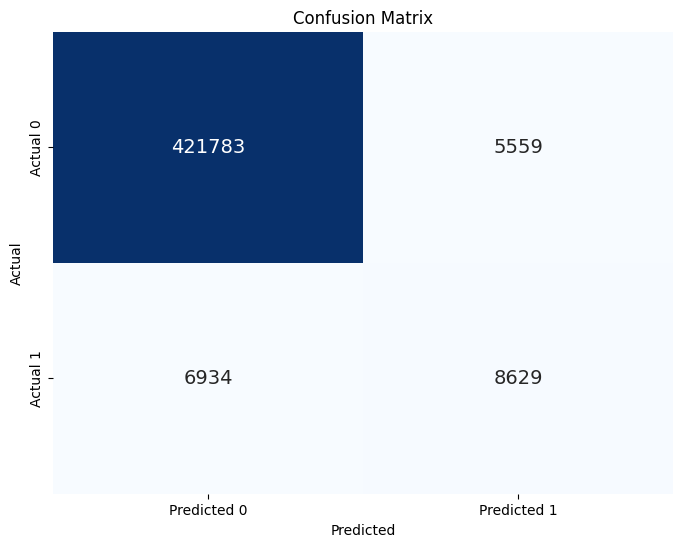

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    427342
           1       0.61      0.55      0.58     15563

    accuracy                           0.97    442905
   macro avg       0.80      0.77      0.78    442905
weighted avg       0.97      0.97      0.97    442905



In [ ]:
# Obtain predictions on the test set
y_pred = lgbclf.predict(X_train_final)

# Create a confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            annot_kws={'size': 14}, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_train, y_pred))

In [ ]:
# Obtain predictions and calculate ROC AUC scores for the training set
pred_train = lgbclf.predict_proba(X_train_final)[:, 1]
train_auc = roc_auc_score(y_train, pred_train)
print('Train ROC accuracy: {}'.format(train_auc))

# Obtain predictions and calculate ROC AUC score for the test set
pred_test = lgbclf.predict_proba(X_test_final)[:, 1]
test_auc = roc_auc_score(y_test, pred_test)
print('Test ROC accuracy: {}'.format(test_auc))

Train ROC accuracy: 0.9249360828115829
Test ROC accuracy: 0.8890612570562306


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Initialize XGBoost classifier
xgbclf = xgb.XGBClassifier(
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=4,
    n_estimators=1000,
    gamma=0,  # Equivalent to LightGBM's min_gain_to_split
    subsample=0.8,
    colsample_bytree=0.9,
    objective='binary:logistic',
    reg_alpha=0.3,
    scale_pos_weight=scale_pos_weight,
    reg_lambda=0.243,
    missing=-999,
    tree_method='gpu_hist',
    seed=27
)

# Train the model on the entire training set
xgbclf.fit(X_train_final, y_train)
print('Model trained successfully')


Model trained successfully


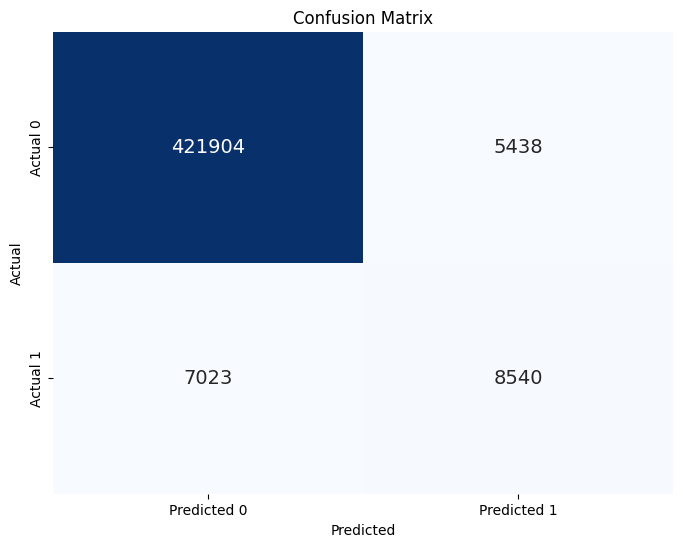

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    427342
           1       0.61      0.55      0.58     15563

    accuracy                           0.97    442905
   macro avg       0.80      0.77      0.78    442905
weighted avg       0.97      0.97      0.97    442905



In [ ]:
# Obtain predictions on the test set
y_pred = xgbclf.predict(X_train_final)

# Create a confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            annot_kws={'size': 14}, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_train, y_pred))

In [ ]:
# Obtain predictions and calculate ROC AUC scores for the training set
pred_train_xgb = xgbclf.predict_proba(X_train_final)[:, 1]
train_auc_xgb = roc_auc_score(y_train, pred_train_xgb)
print('Train ROC accuracy: {}'.format(train_auc_xgb))

# Obtain predictions and calculate ROC AUC score for the test set
pred_test_xgb = xgbclf.predict_proba(X_test_final)[:, 1]
test_auc_xgb = roc_auc_score(y_test, pred_test_xgb)
print('Test ROC accuracy: {}'.format(test_auc_xgb))

Train ROC accuracy: 0.9239824867169423
Test ROC accuracy: 0.8842419116873256


In [ ]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
lgbclf = lgb.LGBMRegressor(
    learning_rate= 0.01,
    metric = 'auc',
    objective = 'binary',
    device = 'gpu',
    subsample= 0.8,
    reg_alpha=0.5,
    max_depth= 9,
    num_leaves=20,
    n_estimators=1000,
    colsample_bytree=0.5,   
    boosting_type="gbdt",
    scale_pos_weight=scale_pos_weight,
    seed = 27
    )
xgbclf = xgb.XGBRegressor(
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=4,
    n_estimators=1000,
    gamma=0,  # Equivalent to LightGBM's min_gain_to_split
    subsample=0.8,
    colsample_bytree=0.9,
    objective='binary:logistic',
    reg_alpha=0.3,
    scale_pos_weight=scale_pos_weight,
    reg_lambda=0.243,
    missing=-999,
    tree_method='gpu_hist',
    seed=27
    )
rfclf = RandomForestRegressor(n_estimators=1000,
                              max_depth=5, 
                                max_features='sqrt', 
                                random_state=27)

In [ ]:
X_train_final=X_train_final.replace(np.inf,-999)
X_train_final=X_train_final.replace(-np.inf,-999)
X_test_final=X_test_final.replace(np.inf,-999)
X_test_final=X_test_final.replace(-np.inf,-999)

In [ ]:
# Define base models
base_models = [lgbclf, xgbclf]

# Define meta model
meta_model = RandomForestClassifier( n_estimators= 1000,
    max_depth= 5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state= 27)

# Create the stacking classifier
stacking_clf = StackingClassifier(classifiers=base_models, meta_classifier=meta_model)

# Fit the stacking classifier
stacking_clf.fit(X_train_final, y_train)

# Obtain predictions on the test set
stacking_pred = stacking_clf.predict_proba(X_test_final)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15563, number of negative: 427342
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 8016
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 78
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 34 dense feature groups (15.21 MB) transferred to GPU in 0.015465 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035138 -> initscore=-3.312688
[LightGBM] [Info] Start training from score -3.312688


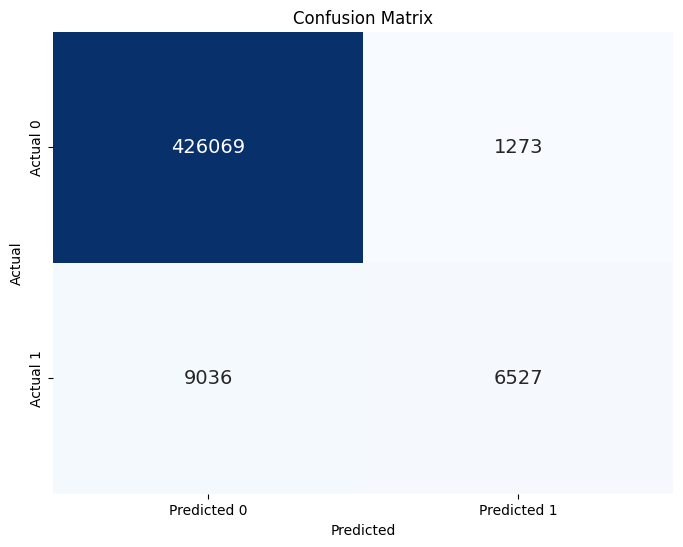

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    427342
           1       0.84      0.42      0.56     15563

    accuracy                           0.98    442905
   macro avg       0.91      0.71      0.77    442905
weighted avg       0.97      0.98      0.97    442905



In [ ]:
# Obtain predictions on the test set
y_pred = stacking_clf.predict(X_train_final)

# Create a confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            annot_kws={'size': 14}, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_train, y_pred))

In [ ]:
from sklearn.metrics import roc_auc_score

# Train AUC
stacking_train_auc = roc_auc_score(y_train, stacking_clf.predict_proba(X_train_final)[:, 1])
print('Stacking Train ROC AUC:', stacking_train_auc)

# Test AUC
stacking_test_auc = roc_auc_score(y_test, stacking_pred)
print('Stacking Test ROC AUC:', stacking_test_auc)

[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Stacking Train ROC AUC: 0.9207573707800603
Stacking Test ROC AUC: 0.8818302357109399
